In [1]:
import pandas as pd
import sys
from sklearn.linear_model import Lasso
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle


#My functions
sys.path.append('/home/ags72/Documents/MTWDBN/Tools')
from GraphFunctions import graph_to_matrix_6pop_3timeslice
from StatFunctions import calculate_F_score

In [2]:
truemodel= [('I1_t1','I1_t3'), ('E1_t1','E1_t3'), ('I2_t1','I2_t3'), ('E2_t1','E2_t3'), ('I3_t1','I3_t3'), ('E3_t1','E3_t3'),
            ('I1_t1','E1_t3'), ('E1_t1','I1_t3'), ('I2_t1','E2_t3'), ('E2_t1','I2_t3'), ('I3_t1','E3_t3'), ('E3_t1','I3_t3'),
            ('E2_t1','E1_t3'), ('E1_t1','E3_t3'),
            ('I1_t2','I1_t3'), ('E1_t2','E1_t3'), ('I2_t2','I2_t3'), ('E2_t2','E2_t3'), ('I3_t2','I3_t3'), ('E3_t2','E3_t3'),
            ('I1_t2','E1_t3'), ('E1_t2','I1_t3'), ('I2_t2','E2_t3'), ('E2_t2','I2_t3'), ('I3_t2','E3_t3'), ('E3_t2','I3_t3'),
            ('E2_t2','E1_t3'), ('E1_t2','E3_t3')]
           

true_graph = graph_to_matrix_6pop_3timeslice(truemodel)[0:6,:] #Only look at one timeslice, discovered edges can be present in any timelayer

In [3]:
#Calculate optimal alpha using 0-neurons dropped condition
timelags = 3
alphas = np.arange(0.005,0.05, 0.005)#[0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]

spikes_df_all = pd.read_csv('Alec Dataframes/laminar2_spikes_drop_0_iteration_1.csv', index_col = 0)

F_scores_alphas = []
recalls_alphas = []
precisions_alphas = []

for alpha in alphas:

    all_pops = list(spikes_df_all.columns)
    to_pops = [pop for pop in all_pops if pop.endswith('t{}'.format(timelags))]


    LASSO_graph = np.zeros((12,6))
    for idx,to_pop in enumerate(to_pops):
        X = spikes_df_all.drop(to_pop, axis = 1)
        y = spikes_df_all[to_pop]

        lasso = Lasso(alpha=alpha)
        lasso.fit(X, y)
        LASSO_graph[:,idx] = lasso.coef_[0:12] != 0
    
    
    LASSO_edges = np.logical_or(LASSO_graph[0:6,:], LASSO_graph[6:12,:]) #Edges are allowed to be detected in either time slice
    
    F_score, recall, precision = calculate_F_score(true_graph, LASSO_edges, False)
    F_scores_alphas.append(F_score)
    recalls_alphas.append(recall)
    precisions_alphas.append(precision)
    
    print('alpha: {alpha}, F-Score: {F_score}, Recall: {recall}, Precision: {precision}'.format(alpha = alpha, F_score = F_score, recall = recall, precision = precision))

alpha: 0.01, F-Score: 0.7058823529411764, Recall: 0.8571428571428571, Precision: 0.6
alpha: 0.015, F-Score: 0.75, Recall: 0.8571428571428571, Precision: 0.6666666666666666
alpha: 0.02, F-Score: 0.7586206896551724, Recall: 0.7857142857142857, Precision: 0.7333333333333333
alpha: 0.025, F-Score: 0.7407407407407408, Recall: 0.7142857142857143, Precision: 0.7692307692307693
alpha: 0.03, F-Score: 0.7200000000000001, Recall: 0.6428571428571429, Precision: 0.8181818181818182


Text(0.5, 1.0, 'LASSO Performance as Function of Alpha')

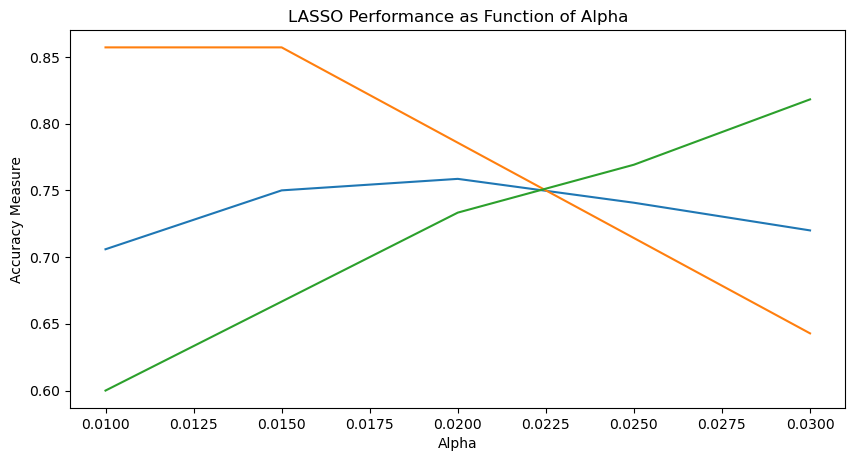

In [24]:
fig, ax = plt.subplots(figsize = (10,5),dpi = 100)

ax.plot(alphas, F_scores_alphas, label = 'F-score')
ax.plot(alphas, recalls_alphas, label = 'Recall')
ax.plot(alphas, precisions_alphas, label = 'Precison')
ax.set_xlabel('Alpha')
ax.set_ylabel('Accuracy Measure')
ax.set_title('LASSO Performance as Function of Alpha')

# Alpha = 0.02 is Optimal for no dropped neurons, use that alpha

In [34]:
#Non-Shuffle Graphs

F_scores = { 0:[],
            20:[],
            40:[],
            60:[],
            80:[]}

recalls = {  0:[],
            20:[],
            40:[],
            60:[],
            80:[]}

precisions = {0:[],
             20:[],
             40:[],
             60:[],
             80:[]}


#First do 0 neurons dropped, there is only 1 iteration since there can be no variability in which neurons were dropped
F_scores[0].append(F_scores_alphas[np.argmax(F_scores_alphas)])
recalls[0].append(recalls_alphas[np.argmax(F_scores_alphas)])
precisions[0].append(precisions_alphas[np.argmax(F_scores_alphas)])

for drop in tqdm([20,40,60,80]):
    for iteration in [1,2,3,4,5]:
        spikes_df_all = pd.read_csv('Alec Dataframes/laminar2_spikes_drop_{drop}_iteration_{iteration}.csv'.format(drop=drop, iteration = iteration), index_col = 0)

        all_pops = list(spikes_df_all.columns)
        to_pops = [pop for pop in all_pops if pop.endswith('t{}'.format(timelags))]
        

        LASSO_graph = np.zeros((12,6))
        for idx,to_pop in enumerate(to_pops):
            X = spikes_df_all.drop(to_pop, axis = 1)
            y = spikes_df_all[to_pop]
            
            lasso = Lasso(alpha=0.02)
            lasso.fit(X, y)
            
            LASSO_graph[:,idx] = lasso.coef_[0:12] != 0
        
        LASSO_edges = np.logical_or(LASSO_graph[0:6,:], LASSO_graph[6:12,:]) #Edges are allowed to be detected in either time slice
        F_score, recall, precision = calculate_F_score(true_graph, LASSO_edges, False)
        F_scores[drop].append(F_score)
        recalls[drop].append(recall)
        precisions[drop].append(precision)

100%|████████████████████████████████████████████| 4/4 [01:35<00:00, 23.98s/it]


In [35]:
F_scores

{0: [0.7586206896551724],
 20: [0.6923076923076924,
  0.6923076923076924,
  0.6923076923076924,
  0.6923076923076924,
  0.6923076923076924],
 40: [0.4761904761904762,
  0.4761904761904762,
  0.4761904761904762,
  0.4761904761904762,
  0.4761904761904762],
 60: [0.25, 0.25, 0.25, 0.25, 0.25],
 80: [0, 0, 0, 0, 0]}

In [36]:
recalls

{0: [0.7857142857142857],
 20: [0.6428571428571429,
  0.6428571428571429,
  0.6428571428571429,
  0.6428571428571429,
  0.6428571428571429],
 40: [0.35714285714285715,
  0.35714285714285715,
  0.35714285714285715,
  0.35714285714285715,
  0.35714285714285715],
 60: [0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285],
 80: [0.0, 0.0, 0.0, 0.0, 0.0]}

In [37]:
precisions

{0: [0.7333333333333333],
 20: [0.75, 0.75, 0.75, 0.75, 0.75],
 40: [0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143],
 60: [1.0, 1.0, 1.0, 1.0, 1.0],
 80: [0, 0, 0, 0, 0]}

In [38]:
import pickle

with open('F_scores_LASSO.pickle', 'wb') as handle:
    pickle.dump(F_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('recalls_LASSO.pickle', 'wb') as handle:
    pickle.dump(recalls, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('precisions_LASSO.pickle', 'wb') as handle:
    pickle.dump(precisions, handle, protocol=pickle.HIGHEST_PROTOCOL)
